<a href="https://colab.research.google.com/github/srujanreddyj/recommendation_systems_corise/blob/main/week3_ann_user_representations_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install faiss-cpu --no-cache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pickle
import faiss
import numpy as np
from decimal import Decimal
from statistics import mean

# **Welcome to week 3 project!**

Congratulations on making it to week 3! 👏 In the first week of this course, we covered the basics of how to design personalized recommendation systems. We then provided some system design examples for large scale recommenders from corporations like Spotify and YouTube, as well as techniques for candidate generation, specifically the two-tower model being used at Twitter and Pinterest.

Last week, we covered details of ML approaches for recommendations: including multi-task recommenders and contextual bandits.

In week 3, we covered various techniques for learning user representations.

In this week's project, we will touch upon two key aspects related to representations:
1. How do we query large amount of vectors in efficient time.
2. How can we infer various user representations and see what their impact is on downstream task.

Lets begin with Part A, which tells us how we could handle a large number of candidate items or user representations in an efficient manner. 


# Part A: Approximate nearest neighbor search

Often we are interested in finding nearest neighbors in a large space of vectors. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. Annoy, Faiss, ScaNN are typical libraries that are used for efficient vector similarity search at scale. They implement algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM.

In the first part of this week's project, we will simulate embeddings of 1 million items and try to find k-nearest neighbours for an item of interest. We will implement a vanilla search function to fetch the top-k nearest neighbors and estimate the time it takes for us to do so. We will then compare this with FAISS -- Facebook's nearest neighbour search library, and compare the time it takes for us to get nearest neighbours from FAISS versus our own implementation.

Lets first generate a simulated dataset of embeddings of 1 million items.

In [34]:
d = 64                           # dimension
nb = 1000000                     # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

Now that we have these items, lets take up the goal of finding the top-5 items closest to this specific item. Your goal is to implement your function to estimate the top-5 items and print the average distance of these top 5 items to the query item.

In [35]:
from scipy.spatial import distance
a = xb[1]
b = xq[1]
dst = distance.euclidean(a, b)
dst

2.883389472961426

In [36]:
k=4
query_vector = xq[2:3]
query_vector

array([[0.20845878, 0.845129  , 0.20550448, 0.94734293, 0.10274749,
        0.6191617 , 0.77583075, 0.09261925, 0.3274397 , 0.85938   ,
        0.924096  , 0.12895997, 0.7560429 , 0.42820475, 0.11612509,
        0.25218487, 0.4510368 , 0.1614575 , 0.47467363, 0.73306215,
        0.27797878, 0.55596507, 0.51724535, 0.38300654, 0.84059364,
        0.39062163, 0.03605831, 0.36499304, 0.00245236, 0.8184168 ,
        0.6431442 , 0.8211902 , 0.803947  , 0.64254075, 0.8942377 ,
        0.3960015 , 0.02801774, 0.33350977, 0.67217875, 0.08496645,
        0.9040858 , 0.16209054, 0.18217625, 0.45620543, 0.81709796,
        0.9457996 , 0.9014344 , 0.07520456, 0.27958974, 0.13733523,
        0.07986983, 0.50559473, 0.04614276, 0.5802821 , 0.18445462,
        0.4851945 , 0.30126095, 0.6018374 , 0.9324023 , 0.02708857,
        0.5009265 , 0.81868106, 0.5303546 , 0.98523957]], dtype=float32)

In [43]:
def find_top_k_nn(query_vector, item_vector, k):
    """
    in this function, implement your definition of top-k nearest neighbours, and return the distances
    and indices of the these top-k items.
    """

    # top_k_pairs_xq = []
    # for i in range(len(query_vector)):
    #   dist = []
    #   for j in range(len(item_vector)):
    #     dist_j = distance.euclidean(item_vector[j], query_vector[i])
    #     dist.append(dist_j)

    query_dist =  item_vector - query_vector
    dist = np.linalg.norm(query_dist, axis=-1) ** 2
    #get k closest  elements
    top_k_inds = np.argpartition(dist, k)[:k]
    top_k_dis = [dist[z] for z in top_k_inds]

    
    return top_k_dis, top_k_inds 

In [44]:
%%time
find_top_k_nn(query_vector, xb, 5)

CPU times: user 232 ms, sys: 9.54 ms, total: 242 ms
Wall time: 433 ms


([4.7423596, 5.0559897, 5.061423, 5.103091, 5.119121],
 array([934893, 201968, 529281, 836119, 808216]))

In [47]:
# %%time

results = pd.DataFrame()

D, I = find_top_k_nn(query_vector, xb, 5)

print("distances from the k nearest neighbor fetched:",D)
print("indices from the k nearest neighbor fetched:",I)
print("average distance of the k- nearest neighbors fetched: ",np.mean(D))



distances from the k nearest neighbor fetched: [4.7423596, 5.0559897, 5.061423, 5.103091, 5.119121]
indices from the k nearest neighbor fetched: [934893 201968 529281 836119 808216]
average distance of the k- nearest neighbors fetched:  5.0163965


With your top-k NN function implemented, call this function to get the top-k nearest neighbor items for the query_vector and print the average distance. Also, print the time it takes to run this function:

Now lets switch to using Faiss https://github.com/facebookresearch/faiss

Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. 

### Similarity search in Faiss

Given a set of vectors x_i in dimension d, Faiss builds a data structure in RAM. After the structure is constructed, when given a new vector x in dimension d it performs efficiently the operation:

$i = argmin_i ||x - x_i||$

where ||.|| is the Euclidean distance (L2).

In Faiss terms, the data structure is an index, an object that has an add method to add x_i vectors. Note that the x_i's are assumed to be fixed. Computing the argmin is the search operation on the index.

### Indexes used by Faiss

1. The inverted file from “Video google: A text retrieval approach to object matching in videos.”, Sivic & Zisserman, ICCV 2003. This is the key to non-exhaustive search in large datasets. Otherwise all searches would need to scan all elements in the index, which is prohibitive even if the operation to apply for each element is fast


2. The product quantization (PQ) method from “Product quantization for nearest neighbor search”, Jégou & al., PAMI 2011. This can be seen as a lossy compression technique for high-dimensional vectors, that allows relatively accurate reconstructions and distance computations in the compressed domain.


3. The three-level quantization (IVFADC-R aka IndexIVFPQR) method from "Searching in one billion vectors: re-rank with source coding", Tavenard & al., ICASSP'11.

We will implement these three indexes from faiss and use each of these three to search the index, and get the top-k nearest neighbour vectors, and estimate the average distance.

Lets first construct the three indexes: index1, index2, index3 based on Flat index, Inverted index and product quantization techniques:

In [48]:
%%time
index1 = faiss.IndexFlatL2(d)   # build the index
index1.add(xb)                  # add vectors to the index
print("total number of vectors indexed = ",index1.ntotal)

total number of vectors indexed =  1000000
CPU times: user 98.5 ms, sys: 0 ns, total: 98.5 ms
Wall time: 101 ms


In [49]:
%%time
nlist = 100
quantizer = faiss.IndexFlatL2(d)  # the other index
index2 = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
index2.train(xb)
index2.add(xb)
print("total number of vectors indexed = ",index2.ntotal)

total number of vectors indexed =  1000000
CPU times: user 2.26 s, sys: 163 ms, total: 2.42 s
Wall time: 1.31 s


In [50]:
%%time
nlist = 100
m = 8
k = 4
quantizer = faiss.IndexFlatL2(d)  # this remains the same
index3 = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)
                                  # 8 specifies that each sub-vector is encoded as 8 bits
index3.train(xb)
index3.add(xb)
print("total number of vectors indexed = ",index3.ntotal)

total number of vectors indexed =  1000000
CPU times: user 46.4 s, sys: 98.5 ms, total: 46.5 s
Wall time: 24.5 s


Now that we have these three indexes, let us query these to fetch the top-k nearest neghbour for our query_vector and compute the average distance we obtain for each.

We will also time these commands, to find out the trade-off between accuracy and latency.

In [51]:
%%time
D, I = index1.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[4.742359  5.055989  5.0614223 5.1030912]]
indices from the k nearest neighbor fetched: [[934893 201968 529281 836119]]
average distance of the k- nearest neighbors fetched:  4.990715
CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 120 ms


In [52]:
%%time
D, I = index2.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[5.1839685 5.4732704 5.579998  5.5801306]]
indices from the k nearest neighbor fetched: [[ 95006 255141 567851 445550]]
average distance of the k- nearest neighbors fetched:  5.454342
CPU times: user 4.24 ms, sys: 61 µs, total: 4.3 ms
Wall time: 9.41 ms


In [53]:
%%time
D, I = index3.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[4.8449755 4.938947  4.9456244 5.156204 ]]
indices from the k nearest neighbor fetched: [[498344 751562 118396  95006]]
average distance of the k- nearest neighbors fetched:  4.9714375
CPU times: user 1.11 ms, sys: 10 µs, total: 1.12 ms
Wall time: 1.41 ms


Running all these, we observe that the product quantization based index is an order of magnitude faster than the inverted index. In terms of accuracy, if we assume that the lower the distance the more accurate the result, FlatIndex gives us the least distance.

### Goal 1 for this week: Implement your k-NN function and time it

The main goal for this part of the project is to implement your vanilla nearest neighbor function and fetch the closest k nearest neighbours to the query vector. Important to note that your implementation will give an exact result, i.e., your implementation will find the exact closest k vectors that will give the minimum distance to the query_vector.

Please compile the results in a table, and compare the average distance obtained and the time it took to query the 1 million vectors. A nice 2D plot would also give you a good idea of the speed-accuracy trade-off involved.

In [56]:
import pandas as pd
import seaborn as sns

data = {
    'Method': ['Vanilla Knn Linear Scan', 'FAISS Linear Scan', 'FAISS IVF', 'FAISS IVF + PQ'],
    'Average distances': [5.0163965, 4.990715, 5.454342, 4.9714375],
    'Total CPU time (ms)': [433, 120, 9.41, 1.41]
}
data_df = pd.DataFrame(data)


[Text(0, 0.5, 'Wall-Time'),
 Text(0.5, 0, 'Closest NN Distance to Query Vector'),
 Text(0.5, 1.0, 'Comparision between various Scans')]

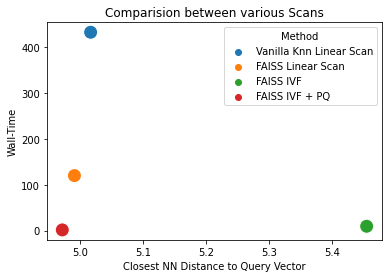

In [64]:
import seaborn as sns
plt = sns.scatterplot(data=data_df, 
                x="Average distances", 
                y="Total CPU time (ms)", 
                hue="Method",
                s=200)

plt.set(xlabel ="Closest NN Distance to Query Vector", ylabel = "Wall-Time", title ='Comparision between various Scans')

# Part B: User representations

In the second part of this week's project, we wish to understand few ways of estimating user representations, and how it impacts the performance of downstream tasks.

To this end, we will work on top of our H&M dataset, and develop a few different ways of representing users.

The broader framework here will be -- we fix the article representations, and fix the downstream task, and then vary the user representations and see how the performance of the downstream task changes based on different user representation techniques.


In [ ]:
!pip install lightgbm

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import datetime
import itertools
import os
from contextlib import redirect_stdout
from tqdm.notebook import tqdm

While we have used neural models so far, lets try a tree based model for this task. We use LightGBM library to train the main model. Lets set up few parameters for the lightgbm model, and specify some additional parameters:

In [ ]:
rand = 64
lgb_params = {
    "objective": "binary",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 40,
    "subsample": 0.8,
    "subsample_freq": 1,
    "bagging_seed": rand,
    "learning_rate": 0.05,
    "feature_fraction": 0.6,
    "min_data_in_leaf": 100,
    "lambda_l1": 0,
    "lambda_l2": 0,
    "random_state": rand,
    "metric": "auc",#"binary_logloss",
    "verbose": -1
}

tran_dtypes = {"t_dat":"str",
               "customer_id":"str",
               "article_id":"int",
               "product_code":"int",
               "price":"float",
               "sales_channel_id":"int"}
art_dtypes = {"article_id":"int",
              "product_code":"int",
              "product_type_no":"int",
              "graphical_appearance_no":"int",
              "colour_group_code":"int",
              "department_no":"int",
              "index_code":"str",
              "index_group_no":"int",
              "section_no":"int",
              "garment_group_no":"int"}
cust_dtypes = {"customer_id":"str"}

obj = "class" # "class" or "rank"
N = 15000
n_iter = 2 # num of iteration
idx_file = "exp1"
n_round = 2000
n_splits = 1
nobuy = 20 # num of negative samples

While we vary the user represnetations, we will keep the article representation fixed. The code below reads the article.csv file and extracts a number of features to represent articles.

In [ ]:
path = "hmdata/"
df = pd.read_csv(path+"articles.csv.zip")

## Find categorical columns
ohe_columns = []
total = 0

for col in df.columns:
    if df[col].dtype == "int64" and len(df[col].unique()) <= 500:
        ohe_columns.append(col)
        total += len(df[col].unique())
        
## Do one hot encoding of the above categorical variables
V = pd.get_dummies(df[ohe_columns], columns=ohe_columns).values


## Get article features
tfidf = TfidfVectorizer(min_df=3)
V_desc = tfidf.fit_transform(df["detail_desc"].fillna("nodesc"))

## Represent articles as vector of size 512
EMB_SIZE = 128
V = np.hstack([V.astype("float32"), V_desc.todense()])
svd = TruncatedSVD(n_components=EMB_SIZE, random_state=0)
svd.fit(V)
V = svd.transform(V)

np.save("articles.npy", V)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [ ]:
def item_representation_1():
    df_art = pd.read_csv(path+"articles.csv.zip")#,dtype=art_dtypes)
    le = LabelEncoder()
    le.fit(df_art["index_code"].unique())
    df_art["index_code"] = le.transform(df_art["index_code"])
    
    dict_vec = {}
    vec_art = np.load("articles.npy")
    df_vec = pd.concat([df_art["article_id"],pd.DataFrame(vec_art)],axis=1)
    for i in range(len(vec_art)):
        dict_vec[df_art["article_id"][i]] = vec_art[i]
    del vec_art,df_vec
    
    return df_art, dict_vec
    

In [ ]:
path = "hmdata/"
df_art = pd.read_csv(path+"articles.csv.zip")
df_cust = pd.read_csv(path+"customers.csv.zip")
df_trans = pd.read_csv("transactions_train.csv.zip")

In [ ]:
%%time
# df_trans_groupby = df_trans.groupby('customer_id')['article_id']#.apply(list).reset_index(name='list')
df_trans_groupby = df_trans.copy()
trans_list = df_trans.groupby('customer_id')['article_id'].apply(list).to_dict()
# trans_list
# trans_list_test = trans_list.copy()

CPU times: user 54.7 s, sys: 4.02 s, total: 58.7 s
Wall time: 58.7 s


In [ ]:
final_trans_list_df = pd.DataFrame.from_dict(final_trans_list, orient='index')
final_trans_list_df.index.name = 'customer_id'
final_trans_list_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,1.567595,-0.462934,-0.079740,0.107913,0.126759,-0.148355,-0.116087,0.022590,0.015073,-0.093721,...,-0.015446,0.016739,-0.022356,0.013299,0.000129,-0.002355,-0.017938,-0.005494,0.016282,0.007945
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,1.188486,-0.138246,0.219715,-0.147821,0.357985,0.072701,0.122105,-0.108504,-0.038888,-0.004817,...,0.007850,-0.018358,0.001453,0.006608,0.024435,0.015017,0.004309,0.021214,-0.008486,-0.008361
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,1.228561,-0.287283,0.321911,-0.176738,0.092718,0.045223,0.045342,0.035184,0.213247,0.103971,...,-0.003578,-0.019923,0.004659,-0.050970,-0.009845,0.001854,0.005220,0.002617,-0.020436,-0.017185
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,1.711610,-0.894588,-0.450807,0.606224,-0.314727,-0.126163,-0.172181,0.674302,-0.171147,-0.476304,...,-0.002317,0.063460,0.039670,0.150802,0.118965,0.058843,0.089508,-0.104490,0.012366,0.061792
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1.462490,-0.580023,0.155783,0.137606,0.396049,-0.097333,-0.182362,-0.006780,0.093760,-0.018613,...,-0.007914,-0.045624,0.010973,-0.056925,-0.019109,-0.039765,-0.054001,0.015857,0.008006,-0.022696


In [ ]:
final_trans_list_df.to_csv('avg_user_embed_2.csv.zip')

In [ ]:
df_cust = user_representation_1()
df_cust_us1 = df_cust.copy()
df_cust_us1.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,1,0,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,1,0,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,1,0,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,1,0,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,1,1,52.0


In [ ]:
df_cust_us2 = df_cust_us1.merge(final_trans_list_df, how='left', on='customer_id')
df_cust_us2 = df_cust_us2.drop('Unnamed: 0', axis=1)
df_cust_us2.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,0,1,2,3,...,118,119,120,121,122,123,124,125,126,127
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,1,0,49.0,1.567595,-0.462934,-0.079740,0.107913,...,-0.015446,0.016739,-0.022356,0.013299,0.000129,-0.002355,-0.017938,-0.005494,0.016282,0.007945
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,1,0,25.0,1.188486,-0.138246,0.219715,-0.147821,...,0.007850,-0.018358,0.001453,0.006608,0.024435,0.015017,0.004309,0.021214,-0.008486,-0.008361
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,1,0,24.0,1.228561,-0.287283,0.321911,-0.176738,...,-0.003578,-0.019923,0.004659,-0.050970,-0.009845,0.001854,0.005220,0.002617,-0.020436,-0.017185
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,1,0,54.0,1.711610,-0.894588,-0.450807,0.606224,...,-0.002317,0.063460,0.039670,0.150802,0.118965,0.058843,0.089508,-0.104490,0.012366,0.061792
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,1,1,52.0,1.462490,-0.580023,0.155783,0.137606,...,-0.007914,-0.045624,0.010973,-0.056925,-0.019109,-0.039765,-0.054001,0.015857,0.008006,-0.022696


In [ ]:
# df_cust_us2.to_csv('df_cust_us2.csv.zip')
print('loading the user_embeding 2 file')
df_cust_us2 = pd.read_csv('df_cust_us2.csv.zip')

loading the user_embeding 2 file


Taken together, the two cells above give us all the features we want to represent articles.

Now lets define some functions to extract user representations. The different functions will contain different ways of representing users.

We bootstrap by providing a simple set of features to represent users in user_representation_1(). This function returns the dataframe of user features.

In [ ]:
def user_representation_1():
    df_cust = pd.read_csv(path+"customers.csv.zip")#,dtype=cust_dtypes)
    df_cust["age"] = df_cust["age"].fillna(df_cust["age"].mean())
    df_cust[["FN","Active"]] = df_cust[["FN","Active"]].fillna(0)
    df_cust["club_member_status"] = df_cust["club_member_status"].apply(lambda x:1 if x == "ACTIVE" else 0)
    df_cust["fashion_news_frequency"] = df_cust["fashion_news_frequency"].apply(lambda x:0 if x == "NONE" else 1)
    df_cust = df_cust.drop(["postal_code"], axis=1)
    return df_cust

In [ ]:
def user_representation_2():
    """
    TODO -- compute user representations as the average
    of the embeddings of the recently purchased articles
    return user representation

    Hint: You may find pd.DataFrame(item_representation_1()[1]).transpose() useful
    """
    df_article_embed = pd.DataFrame(item_representation_1()[1]).transpose().rename_axis('article_id').reset_index()#.to_dict()#
    df_article_embed['article_id'] = df_article_embed['article_id'].astype(str)
    df_article_embed = df_article_embed.set_index('article_id').T.to_dict('list')

    # df_trans_groupby = df_trans.copy()
    trans_list = df_trans.groupby('customer_id')['article_id'].apply(list).to_dict()
    
    final_trans_list = {}

    for k, dk in trans_list.items():
      for i, x in enumerate(dk):
        # print(i)
        dk[i] = df_article_embed.get(str(x))
      final_trans_list[k] = np.mean(dk, axis=0)

    final_trans_list_df = pd.DataFrame.from_dict(final_trans_list, orient='index')
    
    final_trans_list_df.index.name = 'customer_id'
    # final_trans_list_df.head()
    # final_trans_list_df.to_csv('avg_user_embed_2.csv.zip')


    df_cust = user_representation_1()
    df_cust_us1 = df_cust.copy()
    # df_cust_us1.head()

    df_cust_us2 = df_cust_us1.merge(final_trans_list_df, how='left', on='customer_id')
    df_cust_us2 = df_cust_us2.drop('Unnamed: 0', axis=1)
    # df_cust_us2.head()

    return df_cust_us2

def user_representation_3():
    """
    OPTIONAL -- compute user representations as the output
    of the doc2vec model.
    https://cs.stanford.edu/~quocle/paragraph_vector.pdf
    Doc2vec model is an embedding learning method
    that enables us to learn representations of a document.
    We treat each user as a document, and the set of articles
    the user has purchased as the set of words in the document.
    """
    return None

As part of the goal for part B of this week's project, please use the above two functions to implement the two user representation techniques mentioned in the project jumpstart.

You can run the rest of the notebook for now, and come back to these functions, implement them and re-run some of the code below and use user_representation_2() (and optionally user_representation_3()) to get the appropriate user features to use to train the model for the downstream task.

Lets write a function that would read the transactions data and return the dataframes for the transactions within the dates we want to consider, along with the dataframes for articles features: df_art and dict_vec.

In [ ]:
path = "hmdata/"
def read_data(day_oldest):
    df_trans = pd.read_csv('transactions_train.csv.zip')#,dtype=tran_dtypes)
    df_trans["t_dat"] = pd.to_datetime(df_trans["t_dat"],format="%Y-%m-%d")

    df_trans = df_trans.query(f"t_dat >= '{day_oldest}'").copy()
    df_trans = df_trans.drop_duplicates(["customer_id","article_id","t_dat"])
    df_art,dict_vec = item_representation_1()
    df_trans = df_trans.merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")

    return df_trans, df_art, dict_vec

Now we have all the ingredients we need -- we have a basic version of user representations and we have the article representations, and transactions data on which we can train our downstream task.

The downstream task we consider is the task of predicting whether or not a user will purchase an article. This is the same task that we have been dealing with in the past 2 weeks.

Lets define a train() function that will consider the start and end dates and split data based on these, generate the training data, do random negative sampling and train the model.

In [ ]:
def train():
    #### Transaction start date say it is from 2019/9/23 and say we take 1 week data
    day_start = datetime.datetime(2019,9,23) - datetime.timedelta(days=6)
    #### Transaction end date
    day_end = datetime.datetime(2019,9,23) - datetime.timedelta(days=0)
    
    ######## Splitting data based on date ###########################
    ####### Train date ###########################################
    ## Let's consider the training data for 1 year
    day_start_hist = day_start - datetime.timedelta(days=366)
    day_end_hist = day_start - datetime.timedelta(days=1)
    
    df_trans, df_art, dict_vec = read_data(day_oldest = datetime.datetime(2018,9,23))
    print('loading the user_embeding 2 file')
    # df_cust = user_representation_1()
    df_cust = user_representation_2()
    # df_cust = df_cust_us2.copy()

    query_date = f"((t_dat >= '{day_start}') and (t_dat <= '{day_end}'))"
    top_art_all = df_trans.query(query_date ).groupby("article_id")["t_dat"].count().sort_values(ascending = False).index[:N].tolist()

    
    ############### Create training data #################################################################################
    
    
    list_df_buy = []
    list_cust =[]
    
    # make positive samples
    print('make positive samples')
    list_df_buy = df_trans.query(f"(t_dat >= '{day_start}') and (t_dat <= '{day_end}') and (article_id in @top_art_all)").drop_duplicates(["customer_id","article_id"])[["customer_id","article_id"]].copy()
    list_df_buy["target"] = 1
    list_cust = list_df_buy["customer_id"].unique().tolist()
        
        
    # make negative samples (random selection)
    print('make negative samples')
    
    list_df_nobuy = pd.concat([pd.DataFrame({"customer_id":x,"article_id":random.sample(top_art_all,nobuy)}) for x in list_cust])
    list_df_nobuy["target"] = 0
    list_train = pd.concat([list_df_buy,list_df_nobuy]).drop_duplicates(["customer_id","article_id"])
    del list_df_nobuy

    # add feature
    print('training data extraction')
    df_train = pd.DataFrame()
    
    ########## Merging item features with the transactions data ###################################################
    list_train = list_train.merge(df_art[["article_id","product_code","product_type_no","graphical_appearance_no","colour_group_code","department_no","index_code","index_group_no","section_no","garment_group_no"]],how="left",on="article_id")
    
    ######### Merging customer data with the above data ######################################
    list_train = list_train.merge(df_cust, how="left", on="customer_id")
    print('training data extraction')
    df_train = df_train.append(list_train)
    del list_train
    gc.collect()
    
    
    # now that we have all the data in place, lets train the lgbm model

    # train lgbm
    X_train = df_train.drop(["customer_id","product_code","product_type_no","department_no","target"],axis=1)
    y_train = df_train["target"]
    del df_train
    
    print('start training')
    X_tr, X_va, y_tr, y_va = train_test_split(X_train,y_train,stratify = y_train)
    d_tr = lgb.Dataset(X_tr, label=y_tr,  free_raw_data=False)
    d_va = lgb.Dataset(X_va, label=y_va,  free_raw_data=False)
    lgbm_model = lgb.train(lgb_params, train_set=d_tr, num_boost_round=n_round, valid_sets=[d_tr,d_va], verbose_eval=500, early_stopping_rounds=100)
    
    print('saving model')
    # save model
    pd.to_pickle(lgbm_model,"lgbm_model_user_emed_2.pkl")
    del X_train, y_train, X_tr, X_va, y_tr, y_va, d_tr, d_va
    gc.collect()
    del df_trans, df_art, df_cust
    gc.collect()
    return 0

In [ ]:
#user_rep_2
train()

loading the user_embeding 2 file
make positive samples
make negative samples
training data extraction
training data extraction


/tmp/ipykernel_109/2247961737.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(list_train)


start training


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[500]	training's auc: 0.894294	valid_1's auc: 0.88389
[1000]	training's auc: 0.915079	valid_1's auc: 0.897033
[1500]	training's auc: 0.928231	valid_1's auc: 0.903896
[2000]	training's auc: 0.938251	valid_1's auc: 0.90851
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.938251	valid_1's auc: 0.90851
saving model


0

In [ ]:
#user_rep_1
train()

/tmp/ipykernel_83/3086720290.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(list_train)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[500]	training's auc: 0.810789	valid_1's auc: 0.80533
[1000]	training's auc: 0.824969	valid_1's auc: 0.816032
[1500]	training's auc: 0.833422	valid_1's auc: 0.821315
[2000]	training's auc: 0.839791	valid_1's auc: 0.824699
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.839791	valid_1's auc: 0.824699


0

We have now trained a light gbm model using user_representation_1() function as the user representation technique. The key goals for part B of this week's project are to implement user_representation_2(), where we represent the user as the average of embeddings of their recently purchased articles.


Once you have implemented the function, please note to change the line:

df_cust = user_representation_1()

to the appropriate function name and run re-train the model. Please report the performance numbers with each of the two user representations.

This should complete the week 3 project!

### Optional task 1: training a Doc2Vec model

If you want an extra challenge, you can try implementing Doc2vec representations in user_representation_3(). The Doc2vec model is an embedding learning method
    that enables us to learn representations of a document.
    We treat each user as a document, and the set of articles
    the user has purchased as the set of words in the document.

In [ ]:
def user_representation_3(trans_df, vec_size=16):
    """
    OPTIONAL -- compute user representations as the output
    of the doc2vec model.
    https://cs.stanford.edu/~quocle/paragraph_vector.pdf
    Doc2vec model is an embedding learning method
    that enables us to learn representations of a document.
    We treat each user as a document, and the set of articles
    the user has purchased as the set of words in the document.
    """
    # This can be done using df_consumed_articles = df_trans.groupby("customer_id", as_index=False).article_id.agg(list)
    # and then by using Gensim's Doc2Vec implementation. However, tuning hyperparams would be complex
    # and the construction of these user representations would once again consume a lot of RAM...

    
    cust_df = pd.read_csv(path+"customers.csv.zip",dtype=cust_dtypes)
    cust_df = cust_df[["customer_id"]]

    cust_df = cust_df[0:500_000]  # NOTE: speed up run time. should be removed for proper runs
    
    # dataframe with col1: customer_id, col2: list of purchases from most recent to oldest
    df = cust_df.merge(trans_df[["customer_id", "article_id", "t_dat"]], on=["customer_id"], how="left").sort_values(by="t_dat", ascending=False).drop(["t_dat"], axis=1).groupby(["customer_id"]).agg(tuple).applymap(list).reset_index()
    
    docs = []

    # prepare documents for model
    for _, row in df.iterrows():
        # todo: consider adding a cap to max number of articles to store
        doc = TaggedDocument(list(row["article_id"]), [row["customer_id"]])
        docs.append(doc)
    
    doc2vec_model = Doc2Vec(docs, vector_size=vec_size, workers=6)
    
    # create dataframe with doc2vec vectors of each customer
    cols = ["customer_id"] + [f"emb_{x}" for x in range(vec_size)]
    out_df = pd.DataFrame(columns=cols)
    
    for _, row in df.iterrows():
        # todo: check if possible to vectorize this operation since quite slow
        ix = row["customer_id"]
        customer_representation = list(doc2vec_model.dv[ix])
        customer_representation.insert(0, ix)
        
        out_df = out_df.append(pd.Series(customer_representation, index=cols), ignore_index=True)
    
    return out_df

### Optional task 2: training a sequential LSTM model

Another optional task here would be to implement user_representation_4() where user representations are learnt by a sequential LSTM model. The LSTM model will need to be trained on a task -- the task itself could be the downstream task of predicting whether or not a user would purchase a given article given a sequence of previous articles. The final hidden layer of the lstm model can be used as the user representation.